# Phase 1 – Exploratory Data Analysis (EDA): Solana Token Panel

## 1. Introduction
- Project scope & dataset overview
- Objective of EDA

## 2. Data Loading and Structure
- Load parquet file
- Overview: shape, token count, date range
- Summary: data types, unique counts, missing values

## 3. Return Analysis
- Compute 12 h and 72 h log-returns
- Histogram and KDE plots of returns
- Skewness and kurtosis metrics
- ACF and PACF of returns and absolute returns

## 4. Missing Value Patterns
- Heatmap/tabular summary of missingness by token and timestamp
- Imputation strategy recommendations

## 5. Correlation and Redundancy
- Pairwise Pearson & Spearman correlations
- Heatmap visualizations
- Collinearity assessment & feature pruning suggestions

## 6. Raw Interval Calibration
- Define ±1 std interval over 36 h returns
- Empirical vs nominal coverage analysis
- Coverage diagnostics plot

## 7. Summary of Key Findings
- Data health status
- Key distributional insights
- Guidance for feature engineering


## Part 1: Load and Overview

In [18]:
# Load and Overview
import pandas as pd
import numpy as np
df = pd.read_parquet("C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/solana_master_raw.parquet")  # your master panel
print(df.shape)                  # rows × columns
print(df.token.nunique(), "tokens")
print(df.timestamp.min(), "–", df.timestamp.max())

(8326, 29)
23 tokens
2024-12-05 00:00:00 – 2025-06-03 12:00:00


In [20]:
# Schema Summary: Data Types, Uniqueness, Missingness
import pandas as pd
import numpy as np

# Shape of dataset
print("Dataset shape:", df.shape)

# Token count (assuming token column exists)
if 'token' in df.columns:
    print("Unique tokens:", df['token'].nunique())

# Time span
print("Date range:", df['timestamp'].min(), "to", df['timestamp'].max())

# Summary of dtypes, unique counts, missing values
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'n_unique': df.nunique(),
    'pct_missing': df.isnull().mean() * 100
}).sort_values(by='pct_missing', ascending=False)

display(summary)


Dataset shape: (8326, 29)
Unique tokens: 23
Date range: 2024-12-05 00:00:00 to 2025-06-03 12:00:00


,dtype,n_unique,pct_missing
holder_count,float64,4734,39.358636
open_usd,float64,6802,18.304108
high_usd,float64,6802,18.304108
low_usd,float64,6802,18.304108
close_usd,float64,6802,18.304108
token_name,object,23,12.635119
volume_usd,float64,6803,12.635119
new_token_accounts,float64,892,9.920730
transfer_count,float64,4502,9.896709
tvl_tvl_change_12h,float64,181,0.552486


# 1.1 Missingness - holder_count

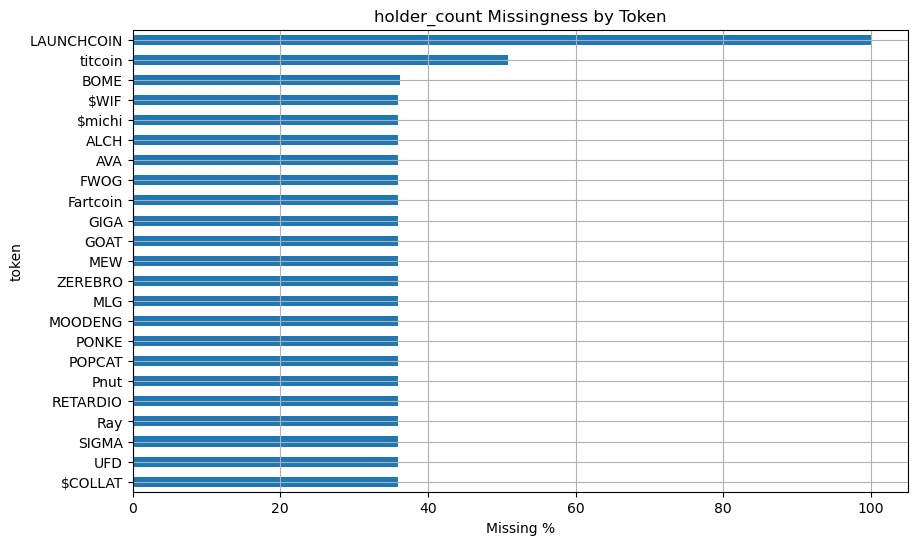

In [31]:
# Looking to why holder_count has such a high level of missing data.

# Percent missing per token
missing_holder_by_token = df.groupby('token')['holder_count'].apply(lambda x: x.isna().mean() * 100).sort_values()

# Plot
import matplotlib.pyplot as plt

missing_holder_by_token.plot(kind='barh', figsize=(10, 6))
plt.xlabel("Missing %")
plt.title("holder_count Missingness by Token")
plt.grid(True)
plt.show()


Launchcoin is missing all of its data for holder_count, titcoin missing 50%, and the rest about 36%. Will looking into this further.

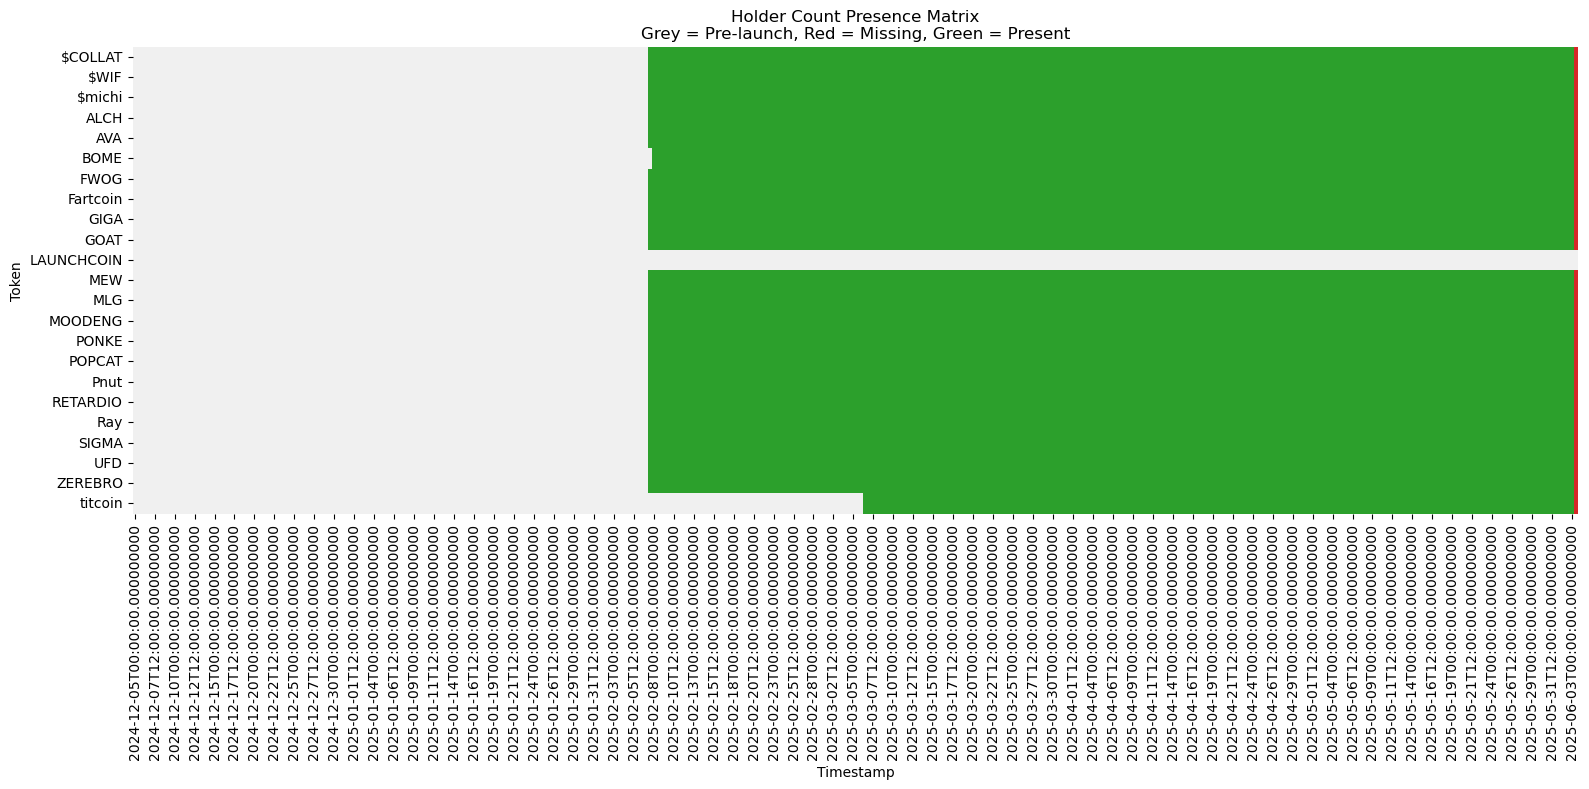

In [51]:
# Checking Temporal Missingness Pattern for holder_count

# Get full token x timestamp grid
tokens = df['token'].unique()
timestamps = df['timestamp'].sort_values().unique()

import itertools
index = pd.MultiIndex.from_product([timestamps, tokens], names=['timestamp', 'token'])
grid = pd.DataFrame(index=index).reset_index()


# Get just the required columns
holder_data = df[['timestamp', 'token', 'holder_count']]

# Merge onto full grid
merged = pd.merge(grid, holder_data, on=['timestamp', 'token'], how='left')


# Dict of token -> first non-null holder_count timestamp
launch_dates = holder_data[holder_data['holder_count'].notna()].groupby('token')['timestamp'].min().to_dict()

# Label each row
merged['period_type'] = merged.apply(
    lambda row: 'pre-launch' if row['timestamp'] < launch_dates.get(row['token'], pd.Timestamp.max)
    else ('present' if pd.notna(row['holder_count']) else 'post-launch-missing'),
    axis=1
)


# Map labels to codes for plotting
code_map = {'pre-launch': 0, 'post-launch-missing': 1, 'present': 2}
merged['status_code'] = merged['period_type'].map(code_map)

# Pivot to matrix
matrix = merged.pivot(index='token', columns='timestamp', values='status_code')

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.heatmap(matrix, cmap=sns.color_palette(['#f0f0f0', '#d62728', '#2ca02c']), cbar=False)
plt.title("Holder Count Presence Matrix\nGrey = Pre-launch, Red = Missing, Green = Present")
plt.xlabel("Timestamp")
plt.ylabel("Token")
plt.tight_layout()
plt.show()


In [38]:
# Find first valid timestamp per token
first_valid = df[df['holder_count'].notna()].groupby('token')['timestamp'].min().sort_values()

print(first_valid)


token
$COLLAT    2025-02-07 12:00:00
UFD        2025-02-07 12:00:00
SIGMA      2025-02-07 12:00:00
Ray        2025-02-07 12:00:00
RETARDIO   2025-02-07 12:00:00
Pnut       2025-02-07 12:00:00
POPCAT     2025-02-07 12:00:00
PONKE      2025-02-07 12:00:00
MOODENG    2025-02-07 12:00:00
MLG        2025-02-07 12:00:00
MEW        2025-02-07 12:00:00
GOAT       2025-02-07 12:00:00
GIGA       2025-02-07 12:00:00
Fartcoin   2025-02-07 12:00:00
FWOG       2025-02-07 12:00:00
AVA        2025-02-07 12:00:00
ALCH       2025-02-07 12:00:00
$michi     2025-02-07 12:00:00
$WIF       2025-02-07 12:00:00
ZEREBRO    2025-02-07 12:00:00
BOME       2025-02-08 00:00:00
titcoin    2025-03-06 12:00:00
Name: timestamp, dtype: datetime64[ns]


### Finding:
Although holder_count shows ~39% missingness across the dataset, this is not due to token launches or random data gaps. Instead, the missingness is structural: on-chain data collection (e.g., holder_count, transfer_count, new_token_accounts) only began on 2025-02-07 12:00:00. Prior to that, no values were collected—even for tokens that existed earlier.

### Key Observations:

LAUNCHCOIN has 100% missing holder_count → drop from all models using this feature.

TITCOIN started receiving data ~1 month after the others → drop for consistency in models involving on-chain data.

Remaining tokens exhibit complete and aligned holder_count coverage from 2025-02-07 onward.

## Modelling Strat moving forward: 

| Model Type                                                 | Data Start                     | Token Filtering                 |
| ---------------------------------------------------------- | ------------------------------ | ------------------------------- |
| **Models using `holder_count` or other on-chain features** | `2025-02-07 12:00:00`          | Drop `LAUNCHCOIN` and `TITCOIN` |
| **Models using only OHLCV / price-based features**         | Full range (2024-12-05 onward) | Include all tokens              |


# 1.2: Full Feature Missingness Audit (Post-Data Start)

In [59]:
# Drop holder_count column and perform missing audit
no_holder_df = df.drop(columns=['holder_count'])

# Compute missing percentage for all remaining columns
missing_summary_alltime = pd.DataFrame({
    'dtype': no_holder_df.dtypes,
    'n_unique': no_holder_df.nunique(),
    'pct_missing': no_holder_df.isnull().mean() * 100
}).sort_values(by='pct_missing', ascending=False)

missing_summary_alltime.style.format({'pct_missing': "{:.2f}%"})

,dtype,n_unique,pct_missing
logret_72h,float64,6616,20.54%
logret_12h,float64,6771,18.68%
open_usd,float64,6802,18.30%
high_usd,float64,6802,18.30%
low_usd,float64,6802,18.30%
close_usd,float64,6802,18.30%
token_name,object,23,12.64%
volume_usd,float64,6803,12.64%
new_token_accounts,float64,892,9.92%
transfer_count,float64,4502,9.90%


C:\Users\james\AppData\Local\Temp\ipykernel_7408\1702298686.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="magma")


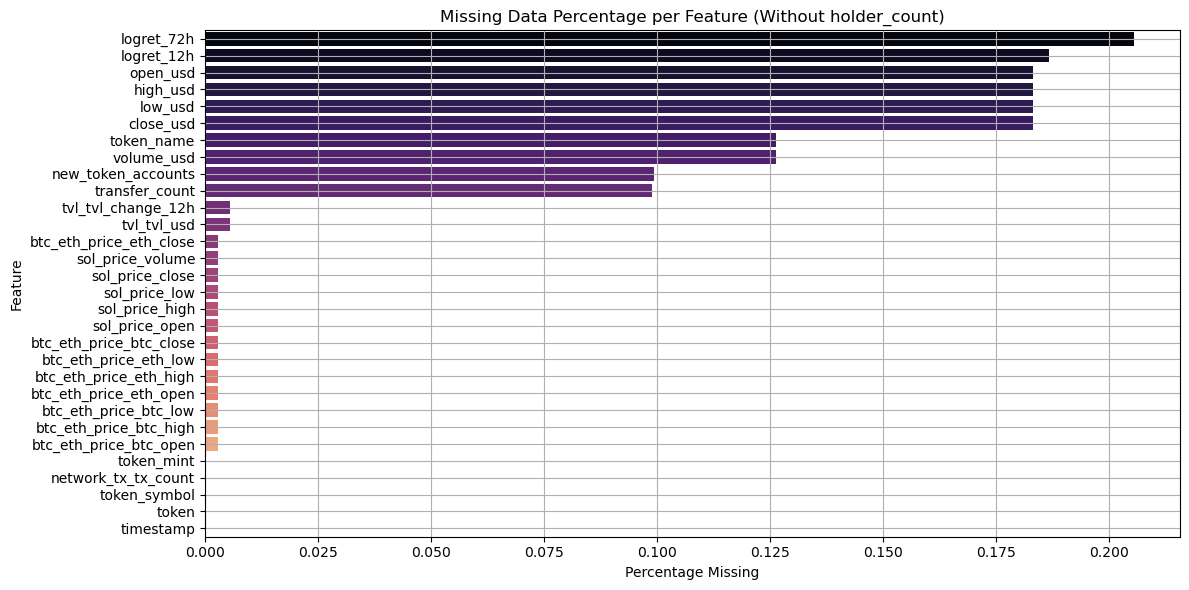

In [63]:
# Visualising missing data
import seaborn as sns
import matplotlib.pyplot as plt

missing_pct = no_holder_df.isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="magma")
plt.title("Missing Data Percentage per Feature (Without holder_count)")
plt.xlabel("Percentage Missing")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

## Research Note: Missingness Audit (Excluding holder_count)
### Finding:
Even when excluding holder_count, key features like OHLCV, new_token_accounts, and transfer_count still exhibit non-trivial missingness:

open_usd, high_usd, low_usd, close_usd, and volume_usd all show ~12–18% missing.

new_token_accounts and transfer_count each show ~10% missing, even outside the on-chain restricted window.

All global market context features (e.g., btc_eth_price_*, sol_price_*, tvl_usd) are nearly complete (<1% missing), indicating reliable ingestion.

### Root Cause:
Missing OHLCV data is likely due to DEX-level outages, indexer delays, or low-liquidity tokens lacking trades in some 12h intervals — not a timestamp misalignment issue. This affects logret_12h and logret_72h, which are derived from close_usd.

## Modeling Strategy (Without holder_count)

| Feature Class                                                    | Handling Plan                                                                                                     |
| ---------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------- |
| **OHLCV (`open/high/low/close/volume`)**                         | Drop rows where any are missing. These are essential for log-return & technical features. Imputation not viable.  |
| **`logret_12h` / `logret_72h`**                                  | Automatically dropped with OHLCV. No separate treatment needed.                                                   |
| **`transfer_count`, `new_token_accounts`**                       | Drop or impute depending on use. For high-signal models: drop rows. For robust baselines: ffill or median impute. |
| **Global Market Features (`sol_price`, `btc_price`, `tvl_usd`)** | Use as-is. Missingness is negligible.                                                                             |
| **Metadata columns** (`token_name`, `token_symbol`, etc.)        | Retain if needed for joining or grouping. Don’t use as inputs.                                                    |


# 1.3: Missingness Post-2025-02-07 Audit

C:\Users\james\AppData\Local\Temp\ipykernel_7408\3758157306.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct_post.values, y=missing_pct_post.index, palette="crest")


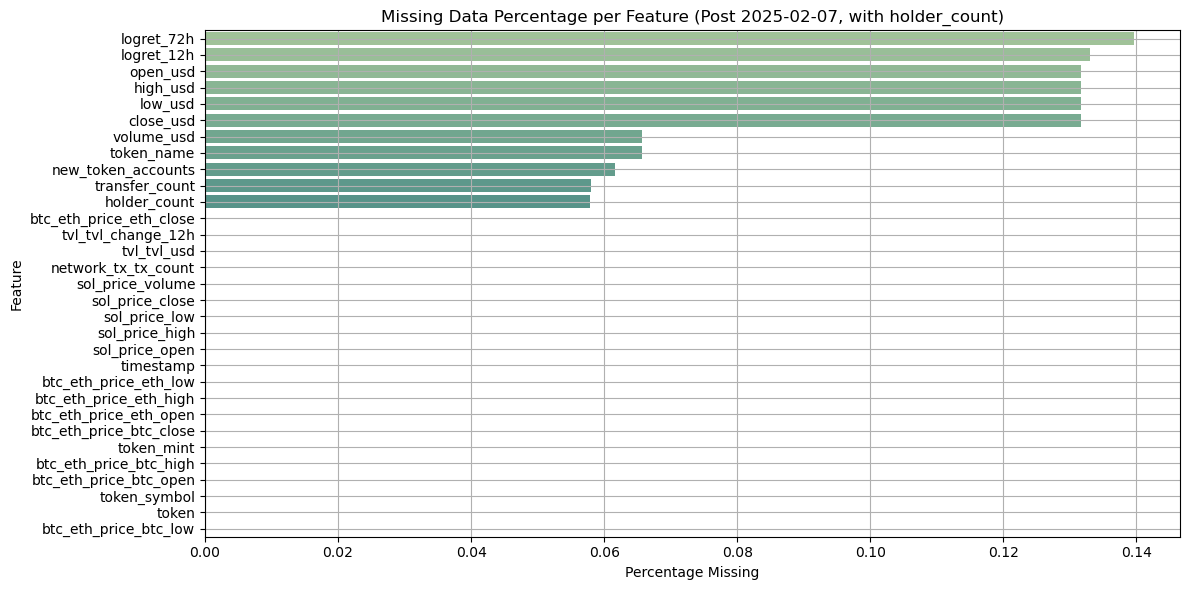

In [71]:
valid_start = pd.Timestamp("2025-02-07 12:00:00")
df_post = df[df['timestamp'] >= valid_start].copy()

missing_summary_post = pd.DataFrame({
    'dtype': df_post.dtypes,
    'n_unique': df_post.nunique(),
    'pct_missing_post_start': df_post.isnull().mean() * 100
}).sort_values(by='pct_missing_post_start', ascending=False)

missing_summary_post.style.format({'pct_missing_post_start': '{:.2f}%'})

import seaborn as sns
import matplotlib.pyplot as plt

missing_pct_post = df_post.isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_pct_post.values, y=missing_pct_post.index, palette="crest")
plt.title("Missing Data Percentage per Feature (Post 2025-02-07, with holder_count)")
plt.xlabel("Percentage Missing")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

## Missingness Audit Post-2025-02-07 (Full Feature Set)

### Finding:
After aligning to the on-chain collection start date (2025-02-07 12:00:00), most features are present with minimal missingness. All core model inputs — including OHLCV, on-chain metrics, and market context features — are reliably captured.

### Summary of Missingness (Post-Start)

| Feature Class                                                          | Missing %       | Comments                                                                             |
| ---------------------------------------------------------------------- | --------------- | ------------------------------------------------------------------------------------ |
| **OHLCV (`open/high/low/close/volume`)**                               | \~12–13%        | Gaps likely due to illiquid intervals or DEX outages. Must be dropped or flagged.    |
| **`logret_12h`, `logret_72h`**                                         | \~14%           | Natural consequence of OHLCV gaps or `shift()` logic. Auto-excluded with OHLCV.      |
| **`holder_count`, `transfer_count`, `new_token_accounts`**             | \~5–6%          | Sparse gaps, likely due to API failures. Can be forward-filled or masked if flagged. |
| **Global market features (`sol_price_*`, `btc_eth_price_*`, `tvl_*`)** | <1%             | Safe to use directly — highly complete.                                              |
| **Metadata (`token_name`, etc.)**                                      | Mostly complete | Non-predictive; used for grouping or joins only.                                     |

### Modeling Strategy (Post-0207, Full Feature Set)

| Scenario                    | Strategy                                                                                    |
| --------------------------- | ------------------------------------------------------------------------------------------- |
| **Core OHLCV rows missing** | Drop these rows entirely — critical for most technical and return-based features.           |
| **On-chain gaps (≤5%)**     | Forward-fill or median-impute. Flag large sequences if needed for calibration.              |
| **Use in production**       | Restrict any live model using `holder_count` to tokens with sufficient post-launch history. |


### Design Implication for make_features(df)
- Must include row-level NA checks for OHLCV before feature engineering.
- Apply conditional forward-fill or imputation for non-OHLCV features if they’re used.
- Consider a valid_row_flag to track if a row passes quality thresholds across all core inputs.

# 1.4: Time-Series OHLCV Missingness Analysis (Full Scope)

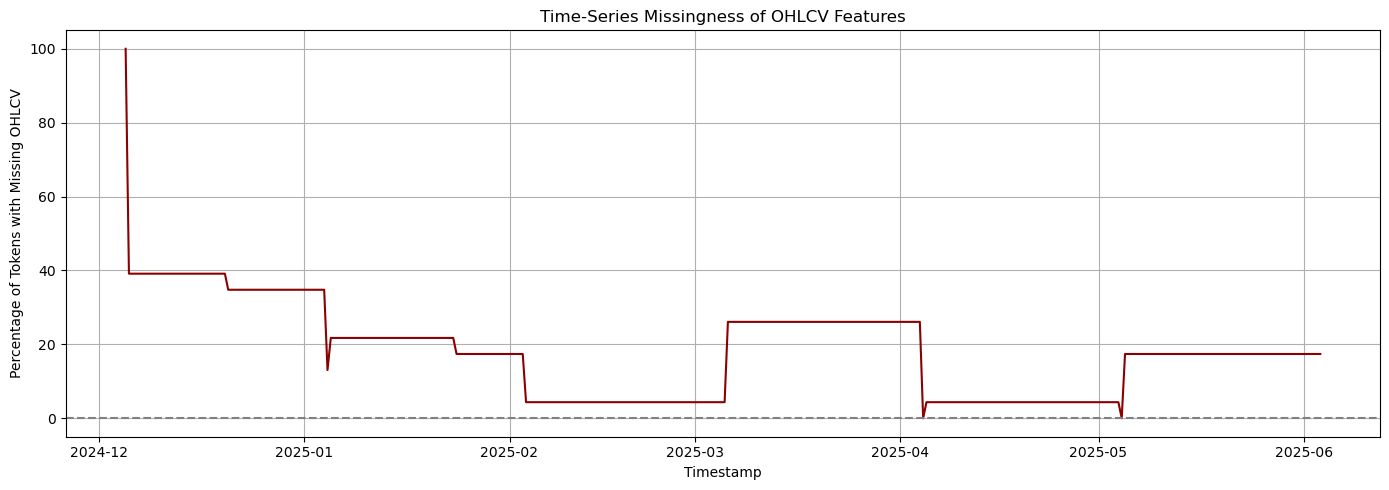

In [83]:
# Define OHLCV columns
ohlcv_cols = ['open_usd', 'high_usd', 'low_usd', 'close_usd', 'volume_usd']

# Create a column for number of missing OHLCV features at each row
df['ohlcv_missing_count'] = df[ohlcv_cols].isnull().sum(axis=1)

# Collapse to binary: 1 if any OHLCV is missing
df['ohlcv_missing_any'] = df['ohlcv_missing_count'] > 0

# Group by timestamp and calculate % of tokens with missing OHLCV data
ts_missing = df.groupby('timestamp')['ohlcv_missing_any'].mean() * 100

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(ts_missing.index, ts_missing.values, color='darkred')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("Time-Series Missingness of OHLCV Features")
plt.ylabel("Percentage of Tokens with Missing OHLCV")
plt.xlabel("Timestamp")
plt.grid(True)
plt.tight_layout()
plt.show()

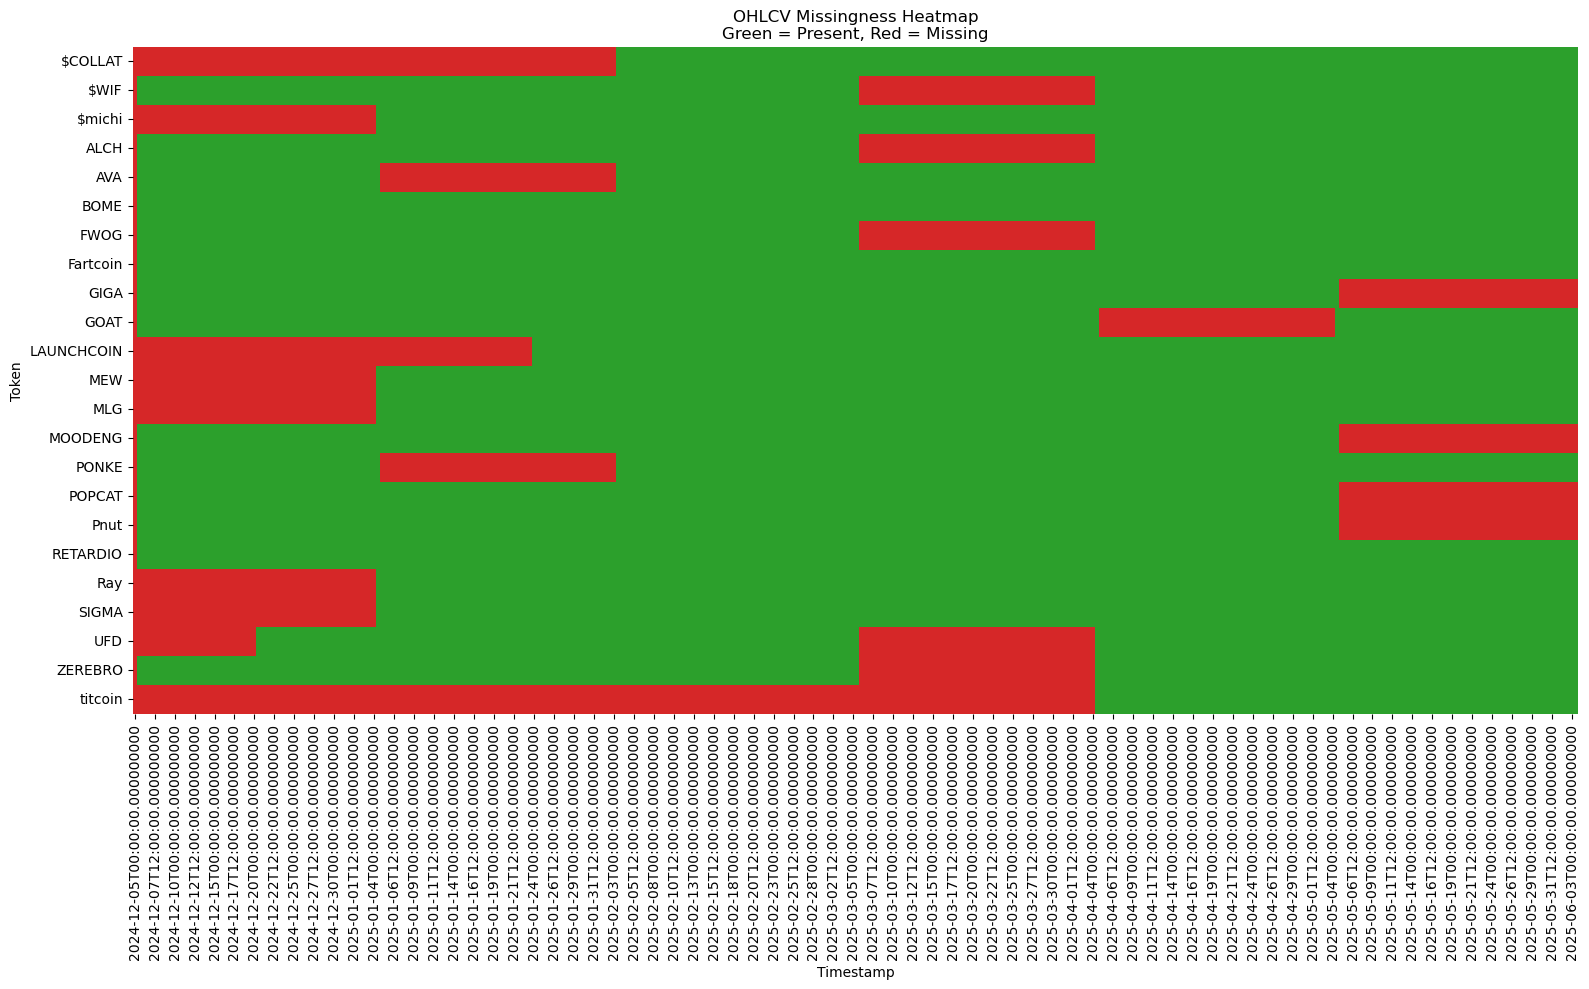

In [85]:
# Binary flag for OHLCV missingness per row (any of open/high/low/close/vol)
df['ohlcv_missing'] = df[ohlcv_cols].isnull().any(axis=1)
# Pivot to a matrix: 1 = missing, 0 = present
pivot_ohlcv = df.pivot_table(index='token', columns='timestamp', values='ohlcv_missing', aggfunc='first')

# Convert boolean to int for clarity
pivot_ohlcv = pivot_ohlcv.fillna(False).astype(int)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_ohlcv, cmap=['#2ca02c', '#d62728'], cbar=False)
plt.title("OHLCV Missingness Heatmap\nGreen = Present, Red = Missing")
plt.xlabel("Timestamp")
plt.ylabel("Token")
plt.tight_layout()
plt.show()


## OHLCV Missingness Categories

| Pattern Type                | Description                                           | Example Tokens                      | Handling Strategy                                                                |
| --------------------------- | ----------------------------------------------------- | ----------------------------------- | -------------------------------------------------------------------------------- |
| **1. Pre-launch Gaps**      | Token not yet listed. Fully red at start.             | `$COLLAT`, `titcoin`                | ✅ Drop or delay modeling until post-launch.                                      |
| **2. Random Internal Gaps** | Scattered red patches in middle of timeline.          | `$WIF`, `FWOG`, `GIGA`, `POPcat`    | ⚠ Flag these rows and optionally impute if gaps are short. Drop otherwise.       |
| **3. Incomplete Starts**    | Late data start despite early timestamp availability. | `MEW`, `RETARDIO`, `ZEREBRO`, `Ray` | ⚠ Drop early periods for those tokens; optionally model only post-stabilisation. |


## Research Note: OHLCV Missingness Analysis
### Finding:
Time-series inspection reveals structured OHLCV missingness due to token launch timing, indexer gaps, and low-liquidity periods. Three missingness types were identified: pre-launch gaps, incomplete starts, and random mid-sequence gaps.

## Modeling Actions:

- Drop tokens with >30% OHLCV missingness (e.g. $COLLAT, titcoin).
- Clip token histories to first valid OHLCV timestamp.
- Drop or forward-fill rows with short internal OHLCV gaps (≤2 steps).
- Apply a post_ohlcv_launch flag to ensure proper filtering per token during rolling CV.

##  Research Note: OHLCV Missingness Strategy & Token Filtering

**Objective:**  
Ensure high-quality OHLCV data for interval forecasting, while preserving as much historical coverage as possible across tokens. Data quality is critical for capturing volatility regimes and return dynamics in a rolling-window modeling setup.

---

###  Key Findings

- `$COLLAT` and `titcoin` have insufficient historical OHLCV coverage due to recent launches → **dropped entirely**.
- Some tokens (e.g. `RETARDIO`, `ZEREBRO`, `MEW`) show late but consistent OHLCV data → **retain, but clip early timestamps**.
- Others exhibit **intermittent OHLCV gaps**, typically due to illiquidity or indexing failure. These require **selective imputation**.

---

### Final Strategy

| Token Type                       | Action                                                                 |
|----------------------------------|------------------------------------------------------------------------|
| **Fully missing** (`$COLLAT`, `titcoin`) | Drop from modeling panel                                                 |
| **Late starter but stable**      | Clip rows before first valid OHLCV                                     |
| **Tokens with patchy gaps**      | Forward-fill up to 2 consecutive 12h intervals, then drop longer gaps  |
| **All rows**                     | Add a `was_imputed` flag for diagnostics and calibration tracking      |

---

###  Rationale

- Avoids cutting the entire dataset to a single token’s history.
- Maintains rolling-window consistency for tokens with solid historical records.
- Preserves return/volatility structure by avoiding aggressive or misleading imputations.
- Ensures clean input to quantile-based models where volatility and tail risk matter.

---

**Next Step:**  
Implement a `clean_ohlcv_panel(df)` function to formalize this logic and plug it directly into the `make_features()` pipeline.
